In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#! pip install pynvml

In [3]:
import torch
# clear cuda cache
torch.cuda.empty_cache()

In [4]:
from pynvml import *
def print_gpu_utilization(_print=True):
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    memory_used = info.used//1024**2
    if _print:
        print(f"GPU memory occupied: {memory_used} MB")
    return memory_used

In [5]:
#! pip install "molfeat[all]"

In [6]:
import torch
import copy
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator

from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns

import datamol as dm

2023-05-27 10:11:51.422350: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
from molfeat.utils.converters import SmilesConverter
from molfeat.trans.pretrained import PretrainedHFTransformer


In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/yamc/main/data/JAK2.smi",sep=" ",names=["SMILES","Name","pIC50"])


In [9]:
df

,SMILES,Name,pIC50
0,CC(C)(C)c1[nH]c2c3cc[nH]c(=O)c3c4cc(ccc4c2n1)F,CHEMBL21156,8.37000
1,CC1CCN(CC1N(C)c2c3cc[nH]c3ncn2)C(=O)CC#N,CHEMBL221959,7.62875
2,CC(COC)Nc1cc(nc(n1)n2cnc3c2cncc3)c4ccoc4,CHEMBL557844,6.85000
3,CC(c1ccc(cc1)F)Nc2cc(nc(n2)n3cnc4c3cncc4)c5ccoc5,CHEMBL221378,7.55000
4,CC(c1ccccc1)Nc2cc(nc(n2)n3cnc4c3cc(cc4)C#N)c5c...,CHEMBL375205,7.54000
...,...,...,...
2247,CNCCn1c2ccc(cc2nc1C3CCC(CC3)O)C(=O)N,CHEMBL3815154,5.41000
2248,CC(Cn1c2ccc(cc2nc1C3CCC(CC3)O)C(=O)N)O,CHEMBL3814406,4.92000
2249,c1cc2c(cc1C(=O)N)nc(n2CCCO)C3CCC(CC3)O,CHEMBL3814951,4.53000
2250,c1cc2c(cc1C(=O)N)nc(n2CCO)C3CCC(CC3)O,CHEMBL3814293,5.50000


In [10]:
class DTset(Dataset):
    def __init__(self, smiles, y, mf_featurizer, max_length=128):
        super().__init__()
        self.smiles = smiles
        self.mf_featurizer = mf_featurizer
        self.y = torch.tensor(y).float()
        # here we use the molfeat mf_featurizer to convert the smiles to
        # corresponding tokens based on the internal tokenizer
        # we just want the data from the batch encoding object
        transformed_mols = dm.utils.parallelized(
                self.mf_featurizer.converter.encode,
                smiles,
                n_jobs=1,
        )
        self.max_length = max_length
        batch_encoding = self.mf_featurizer.featurizer.tokenizer(
            transformed_mols,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length
        )
        self.examples = batch_encoding["input_ids"]
        self.examples = [{"input_ids": torch.tensor(e, dtype=torch.long)} for e in self.examples]
        
    @property
    def embedding_dim(self):
        return len(self.mf_featurizer)

    def __len__(self):
        return self.y.shape[0]
    
    def collate_fn(self, batch, **kwargs):
        # We try to be a bit more clever here, only padding the batch and not the full dataset
        # to reduce padding as much as possible and thus the memory
        y = torch.tensor([feature["y"] for feature in batch]).float()
        inputs_features = [{"input_ids": ft["input_ids"]} for ft in batch]
        batch_inputs = self.mf_featurizer.featurizer.tokenizer.pad(
            inputs_features,
            padding=True,
            return_tensors="pt",
            max_length=self.max_length,
        )
        # If special token mask has been preprocessed, pop it from the dict.
        batch_inputs.update({"y": y})        
        return batch_inputs.data
    
    def __getitem__(self, index):                        
        datapoint = self.examples[index]
        datapoint["y"] = self.y[index]
        return datapoint

In [11]:
# install this
#!pip install pytorch_lightning

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

/home/pwalters/anaconda3/envs/rdkit_2022_03/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [14]:
class AwesomeNetPL(pl.LightningModule):
    def __init__(self,  mf_featurizer, hidden_size=128, dropout=0.1, output_size=1, lr=1e-3):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        # we get the underlying model from the molfeat featurizer
        # here we fetch the "base" huggingface transformer model 
        # and not the wrapper around for MLM
        # this is principally to get smaller model and training efficiency
        base_pretrained_model = getattr(mf_featurizer.featurizer.model, mf_featurizer.featurizer.model.base_model_prefix)
        self.embedding_layer = copy.deepcopy(base_pretrained_model)
        self.embedding_dim = mf_featurizer.featurizer.model.config.hidden_size
        
        # given that we are not concatenating layers, the following is equivalent
        # self.embedding_dim = len(mf_featurizer)
        # we get the the pooling layer from the molfeat featurizer
        self.pooling_layer = mf_featurizer._pooling_obj
        self.hidden_layer = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(len(mf_featurizer), self.hidden_size),
            torch.nn.ReLU()
        )
        self.output_layer = torch.nn.Linear(self.hidden_size, self.output_size)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, *, y=None, **kwargs):
        # get embeddings
        x = self.embedding_layer(**kwargs)
        # we take the last hidden state
        # you could also set `output_hidden_states` to true above 
        # and take x["hidden_states"][-1] instead
        emb = x["last_hidden_state"]
        # run poolings
        h = self.pooling_layer(
            emb,
            kwargs["input_ids"],
            mask=kwargs.get('attention_mask'),
        )
        # run through our custom and optional hidden layer
        h = self.hidden_layer(h)
        # run through output layers to get logits
        return self.output_layer(h)
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        out = self(**batch)
        loss = self.loss_fn(out.squeeze(), batch["y"])
        # Logging to TensorBoard (if installed) by default
        memory_used = print_gpu_utilization(False)
        self.log_dict({"train_loss":loss, 'GPU':memory_used}, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        out = self(**batch)
        loss = self.loss_fn(out.squeeze(), batch["y"])
        # Logging to TensorBoard (if installed) by default
        self.log("valid_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.trainer.model.parameters(), lr=self.lr)
        return optimizer


In [15]:
#featurizer = PretrainedHFTransformer(kind='ChemGPT-1.2B', notation='selfies', dtype=float, preload=True)
featurizer = PretrainedHFTransformer(kind="ChemBERTa-77M-MLM", pooling="bert", preload=True)

model = AwesomeNetPL(featurizer, hidden_size=64, dropout=0.1, output_size=1)

In [16]:
from pytorch_lightning.utilities.model_summary import summarize
summarize(model)

  | Name            | Type         | Params
-------------------------------------------------
0 | embedding_layer | RobertaModel | 3.3 M 
1 | pooling_layer   | BertPooler   | 147 K 
2 | hidden_layer    | Sequential   | 24.6 K
3 | output_layer    | Linear       | 65    
4 | loss_fn         | MSELoss      | 0     
-------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.809    Total estimated model params size (MB)

In [27]:
%matplotlib inline
def train_and_test_model(featurizer, model, batch_size=64, precision=64, accumulate_grad_batches=4, max_epochs=100, devices="auto"):
    dataset = DTset(df.SMILES.values, df.pIC50.values, featurizer)
    generator = torch.Generator().manual_seed(42)
    train_dt, test_dt = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator)
    # collate fn is not called anymore, but instead is a function passed to the dataloader
    train_loader = DataLoader(train_dt, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate_fn)
    test_loader = DataLoader(test_dt, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_fn)
    # select GPU accelerator , possibily explore different strategy
    trainer = pl.Trainer(max_epochs=max_epochs, accelerator="gpu", devices=devices, accumulate_grad_batches=accumulate_grad_batches, precision=precision)
    trainer.fit(model=model, train_dataloaders=train_loader)
    # --- test
    model.eval()
    test_y_hat = []
    test_y_true = []
    with torch.no_grad():
        for data in test_loader:
            for k,v in data.items():
                data[k] = data[k].to(model.device)
            out = model(**data)
            test_y_hat.append(out.detach().cpu().squeeze())
            test_y_true.append(data["y"])
    test_y_hat = torch.cat(test_y_hat).cpu().squeeze().numpy()
    test_y_true = torch.cat(test_y_true).cpu().squeeze().numpy()
    rmse = mean_squared_error(test_y_true, test_y_hat, squared=False)
    r2 = r2_score(test_y_true, test_y_hat)
    print(f"RMSE = {rmse:.2f} R**2 = {r2:.2f}")
    sns.scatterplot(x=test_y_true, y=test_y_hat)
    return trainer, model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/pwalters/anaconda3/envs/rdkit_2022_03/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA Graphics Device') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightni

Training: 0it [00:00, ?it/s]

/home/pwalters/anaconda3/envs/rdkit_2022_03/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


RMSE = 0.95 R**2 = 0.35


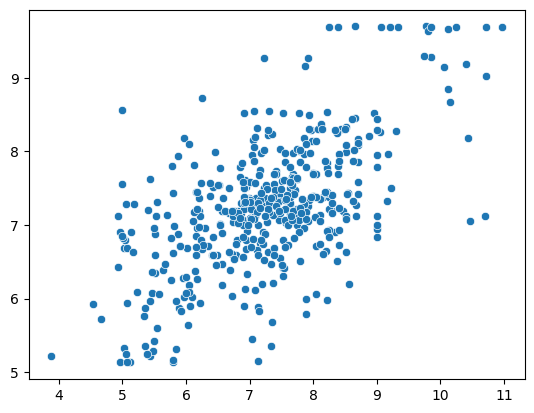

In [28]:
trainer, model = train_and_test_model(featurizer, model, devices=[0])